In [1]:
import pandas as pd
from matplotlib import pyplot as plt

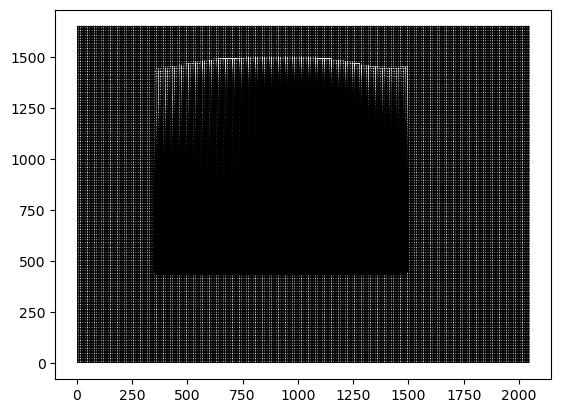

In [2]:
for i in range(4,14):
    df = pd.read_csv('manu/B%04d.csv' % i, delimiter=';')
    plt.quiver(df['x [pixel]'], df['y [pixel]'],df['x-displacement [pixel]'], df['y-displacement [pixel]'])
    plt.savefig('quiver%04d.png' % i)

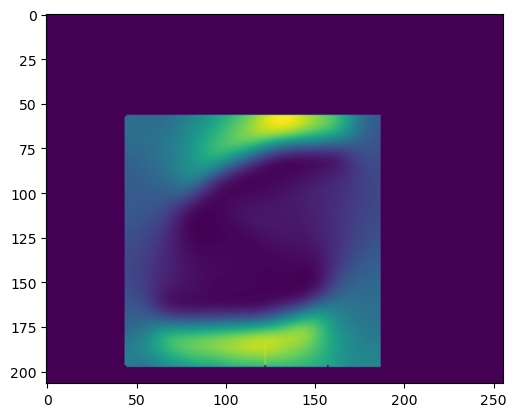

In [3]:
Nx = int((df['x [pixel]'].max())/8 + 1)

Eyy = df['Axial strain Eyy - RC [S]'].to_numpy()
Eyy_im = Eyy.reshape((-1,Nx))
plt.imshow(Eyy_im)

In [4]:
((df['x [pixel]'].max()+4) *(df['y [pixel]'].max()+4))/64, Eyy.shape[0], df['x [pixel]'].max(), df['y [pixel]'].min()

(52992.0, 52992, 2044, 4)

/Users/vt/miniconda3/envs/jaxfem/lib/python3.9/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


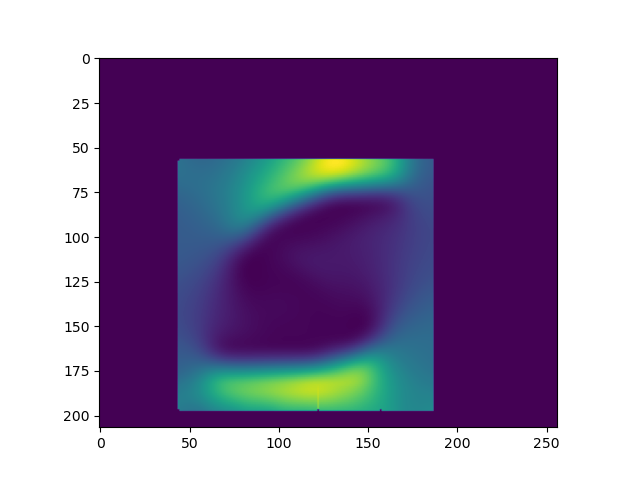

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the interactive Matplotlib backend (notebook or widget)
%matplotlib ipympl
# Create figure and plot elements
fig, ax = plt.subplots()
Nx = int((df['x [pixel]'].max())/8 + 1)

Eyy = df['Axial strain Eyy - RC [S]'].to_numpy()
Eyy_im = Eyy.reshape((-1,Nx))
im = plt.imshow(Eyy_im)

def update(i):
    """Update the plot with the frame number"""
    df = pd.read_csv('manu/B%04d.csv' % (i + 4), delimiter=';')
    Nx = int((df['x [pixel]'].max())/8 + 1)

    Eyy = df['Axial strain Eyy - RC [S]'].to_numpy()
    Eyy_im = Eyy.reshape((-1,Nx))
    im.set_data(Eyy_im)
  # update the data
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=10, interval=1)

# Display the plot
plt.show()


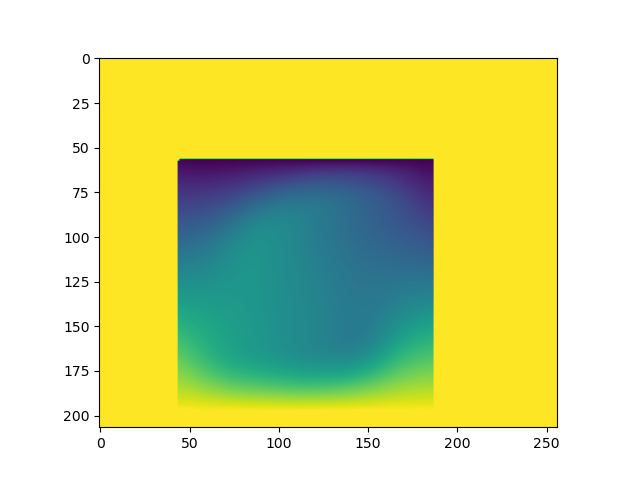

In [7]:
fig, ax = plt.subplots()
Nx = int((df['x [pixel]'].max())/8 + 1)

uy = df['y-displacement [pixel]'].to_numpy()
uy_im = uy.reshape((-1,Nx))
im = plt.imshow(uy_im)

def update(i):
    """Update the plot with the frame number"""
    df = pd.read_csv('manu/B%04d.csv' % (i + 4), delimiter=';')

    uy = df['y-displacement [pixel]'].to_numpy()
    uy_im = uy.reshape((-1,Nx))
    im.set_data(uy_im)
  # update the data
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=10, interval=1)

# Display the plot
plt.show()

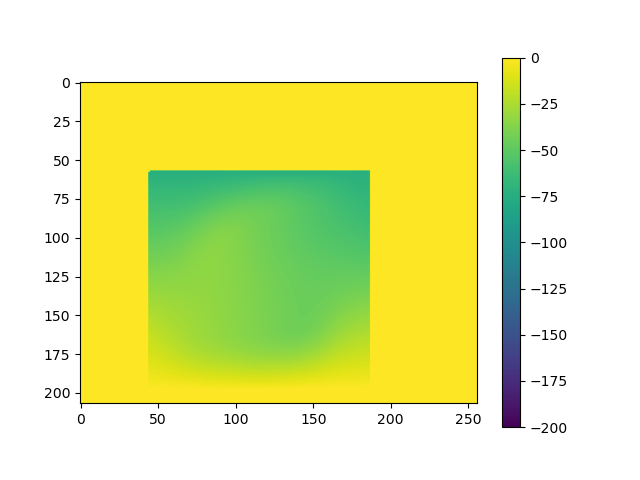

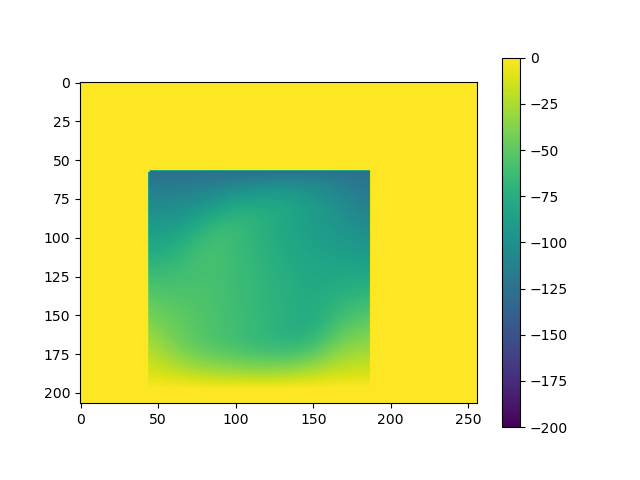

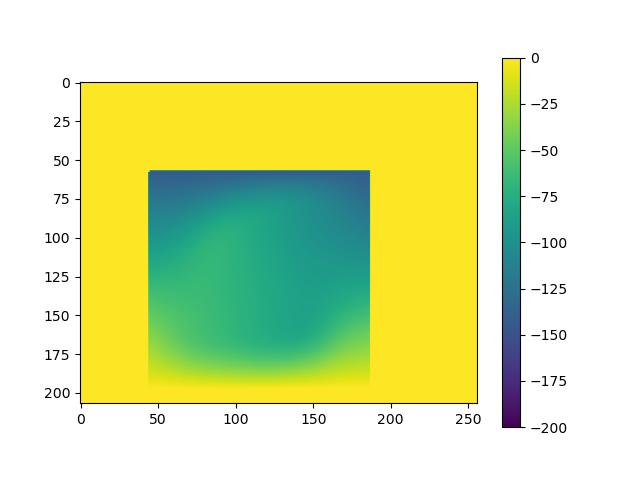

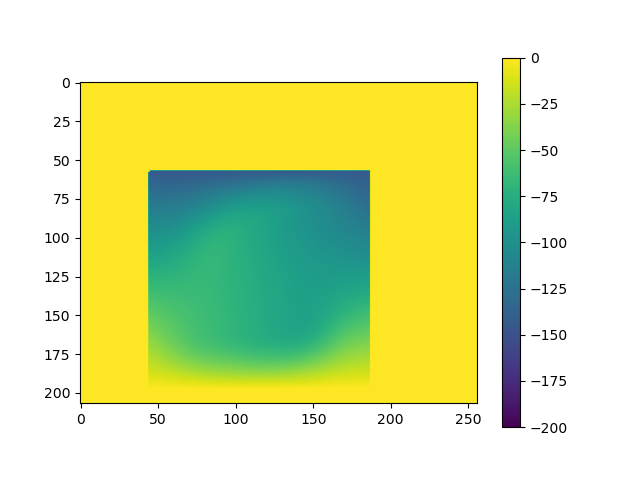

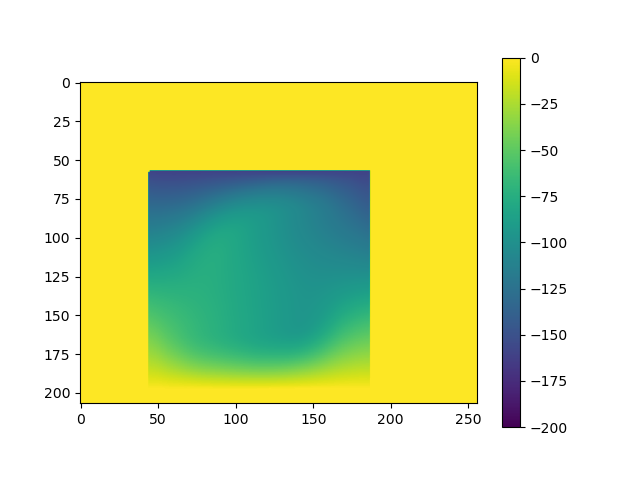

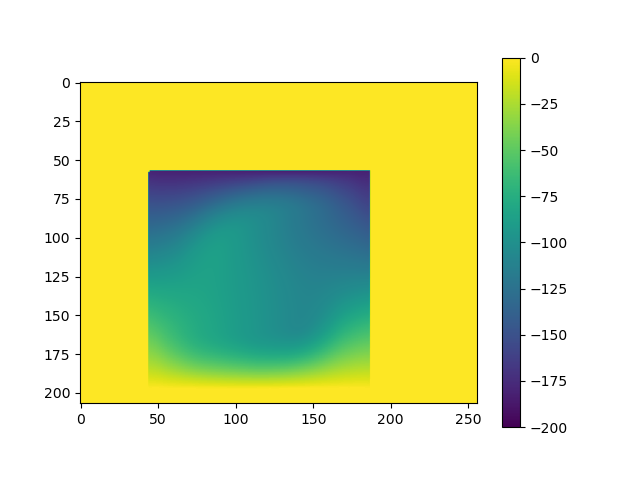

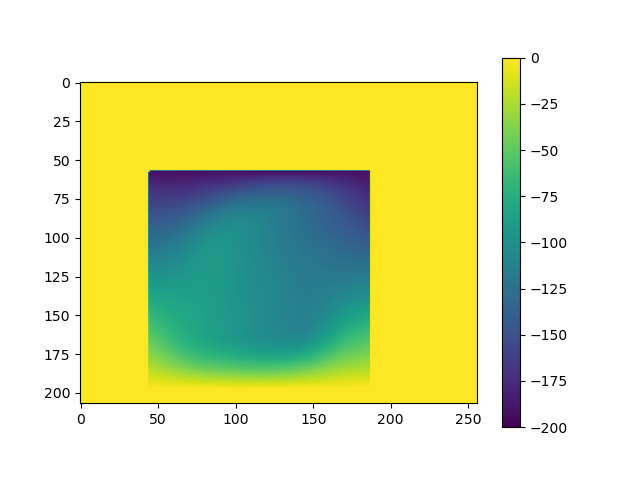

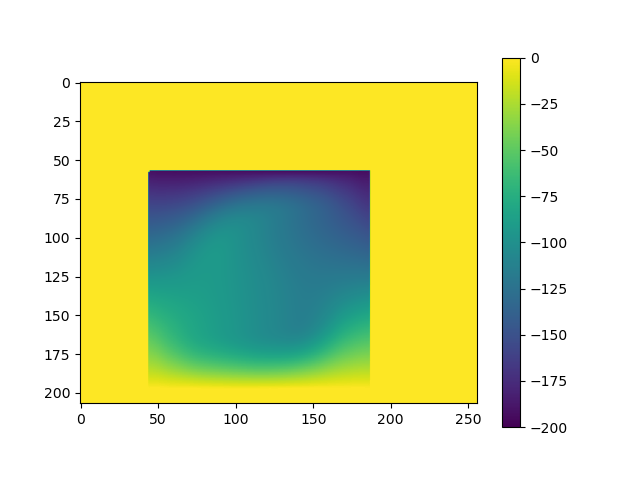

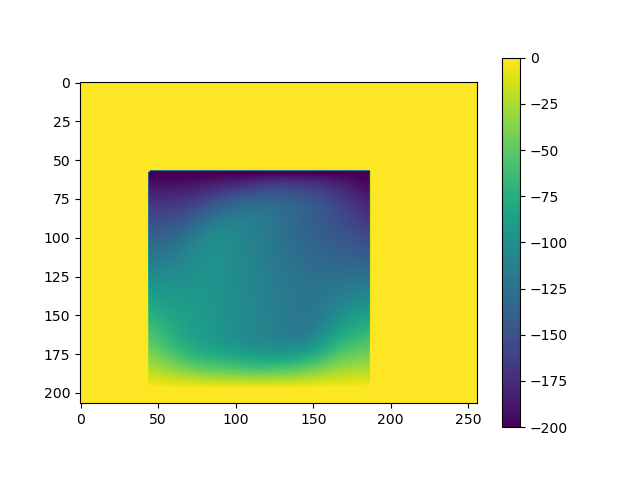

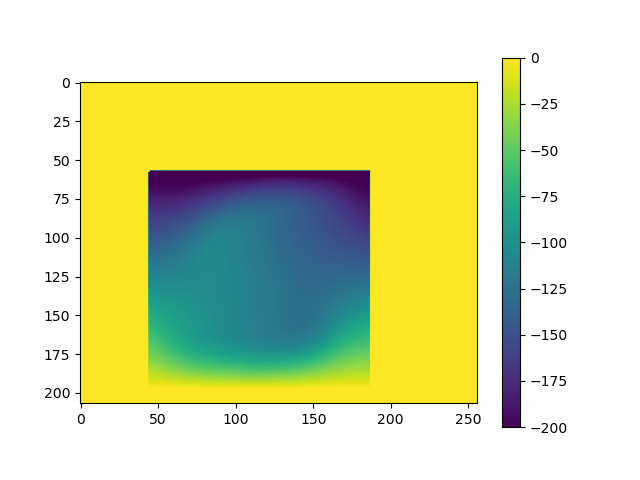

In [5]:
for i in range(10):
    df = pd.read_csv('manu/B%04d.csv' % (i + 4), delimiter=';')
    uy = df['y-displacement [pixel]'].to_numpy()
    uy_im = uy.reshape((-1,Nx))
    plt.figure()
    plt.imshow(uy_im, vmin=-200, vmax = 0)
    plt.colorbar()
    plt.show()

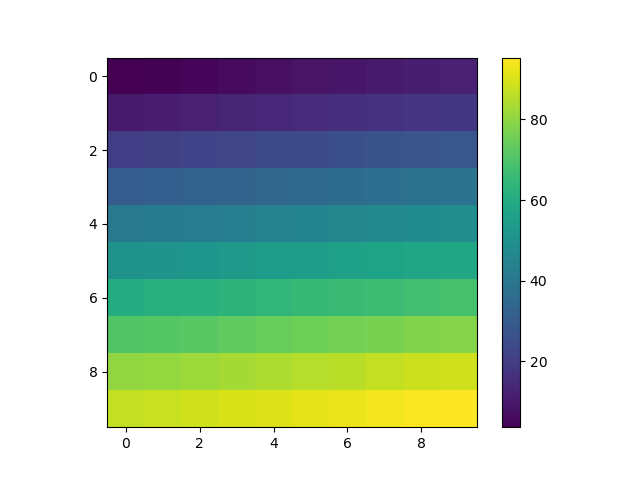

In [8]:

from scipy.linalg import lstsq  # Use JAX compatible method if available

def extract_neighborhood(data, i, j):
    """Extracts a 3x3 neighborhood around pixel (i, j)"""
    # Pad data to handle edges
    padded_data = np.pad(data, 1, mode='edge')
    # Make sure to extract so that (i, j) is the center
    return padded_data[i-1:i+2, j-1:j+2].flatten()

def fit_plane(neighborhood):
    """Fits a plane to a 3x3 neighborhood"""
    # Create coordinates for a 3x3 grid centered at (0, 0)
    x, y = np.meshgrid(np.arange(-1, 2), np.arange(-1, 2))
    x = x.flatten()
    y = y.flatten()
    
    # Formulate the least squares problem Ax = b
    A = np.column_stack([x, y, np.ones(9)])
    b = neighborhood
    
    # Solve the least squares problem
    coeffs, residuals, rank, s = lstsq(A, b, lapack_driver='gelsy')
    return coeffs  # Returns [a, b, c] coefficients of the plane


def process_image(data):
    """Applies plane fitting to each pixel using nested loops"""
    rows, cols = data.shape
    coeffs_matrix = np.zeros((rows, cols, 3))  # To store a, b, c coefficients for each pixel

    for i in range(rows):
        for j in range(cols):
            neighborhood = extract_neighborhood(data, i+1, j+1)  # Account for padding in indices
            coeffs = fit_plane(neighborhood)
            # Store the coefficients at the corresponding pixel position
            coeffs_matrix[i, j] = coeffs

    return coeffs_matrix

# Example usage
data = np.arange(100).reshape(10,10) # Example data, a 10x10 image
plane_params = process_image(data)
plt.figure()
plt.imshow(plane_params[:,:,2])
plt.colorbar()
plt.show()


In [9]:
Nx = int((df['x [pixel]'].max())/8 + 1)

uy = df['y-displacement [pixel]'].to_numpy()
uy = uy.reshape((-1,Nx))

ux= df['x-displacement [pixel]'].to_numpy()
ux = ux.reshape((-1,Nx))

In [10]:
ux_coeff = process_image(ux)
uy_coeff = process_image(uy)

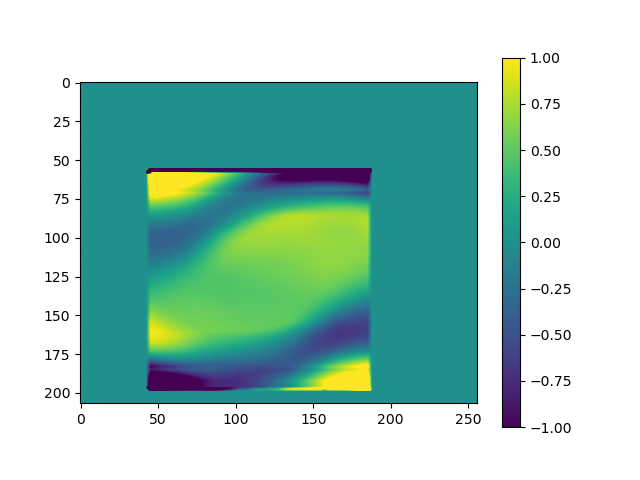

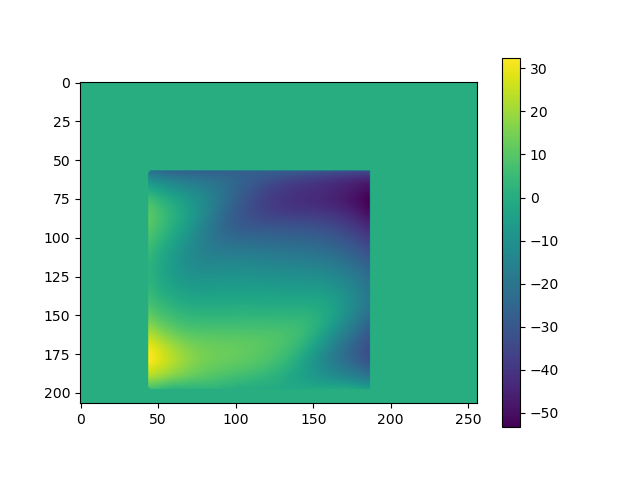

In [11]:
plt.figure()
plt.imshow(ux_coeff[:,:,1], vmin=-1, vmax = 1)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ux)
plt.colorbar()
plt.show()

In [21]:
F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]

F_T = np.transpose(F, axes=(0, 1, 3, 2))

# Matrix multiplication of F^T and F for each pixel
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)


In [13]:
Eyy = df['Axial strain Eyy - RC [S]'].to_numpy()
Eyy = Eyy.reshape((-1,Nx))

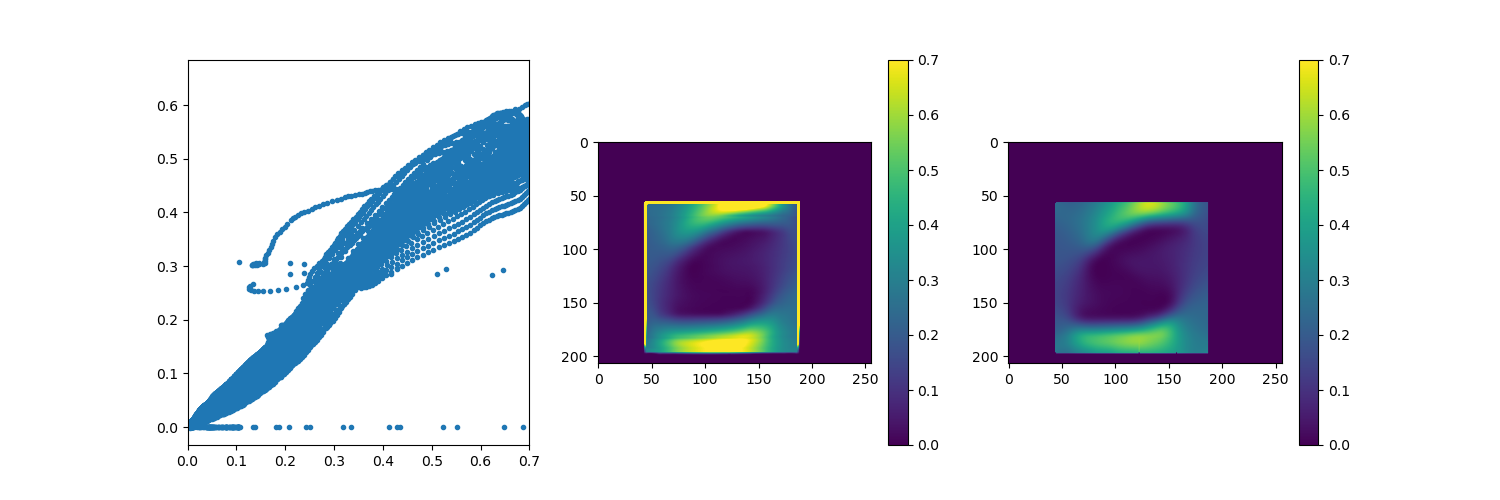

In [63]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(((C[:,:,1,1]-1)*0.5).ravel(), Eyy.ravel(), '.')
plt.xlim((0,.7))
plt.subplot(132)
plt.imshow((C[:,:,1,1]-1)*0.5, vmin=0, vmax=0.7)
plt.colorbar()
plt.subplot(133)
plt.imshow(Eyy, vmin=0, vmax=0.7)
plt.colorbar()